# Learning Using Statistical Invariants

author: Andreas Loehr

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pandas as pd

## Load MNIST data

In [3]:
(x_train, y_train), (x_test,y_test) = mnist.load_data()

In [4]:
# TODO: Illustrate some MNIST samples in grid structure

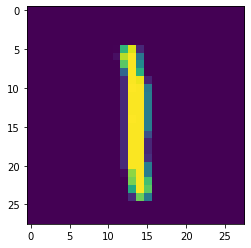

In [5]:
plt.imshow(x_train[14])
# shape: (28,28)

## A simple neural network

In [167]:
# Define a simple neural network with one hidden layer and one output layer
nn_simple = keras.Sequential(
    [
        layers.Flatten(input_shape=(28,28), name="flatten_input"),  # declare shape of one input beforehand
        layers.Dense(500, activation="relu", name="hidden_layer_01"),
        # layers.Dense(10, name="output_layer"),
        layers.Dense(10, name="output_layer"),
    ]
)
# Call model on a test input
x = tf.ones((2,28,28))
y = nn_simple(x)

In [168]:
nn_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_input (Flatten)     (None, 784)               0         
                                                                 
 hidden_layer_01 (Dense)     (None, 500)               392500    
                                                                 
 output_layer (Dense)        (None, 10)                5010      
                                                                 
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________


In [184]:
nn_simple.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    # loss=keras.losses.SparseCategoricalCrossentropy(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

## Preprocessing data

In [6]:
# Preprocess the data (these are NumPy arrays)
# x_train = x_train.reshape(60000, 784).astype("float32") / 255
# x_test = x_test.reshape(10000, 784).astype("float32") / 255

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [186]:
x = tf.constant(x_train)
with tf.GradientTape() as g:
    g.watch(x)
    y = nn_simple.predict(x_train)
dy_dx = g.gradient(y, nn_simple.weights)
print(dy_dx)

LookupError: No gradient defined for operation'IteratorGetNext' (op type: IteratorGetNext). In general every operation must have an associated `@tf.RegisterGradient` for correct autodiff, which this op is lacking. If you want to pretend this operation is a constant in your program, you may insert `tf.stop_gradient`. This can be useful to silence the error in cases where you know gradients are not needed, e.g. the forward pass of tf.custom_gradient. Please see more details in https://www.tensorflow.org/api_docs/python/tf/custom_gradient.

In [185]:
hist_nn_simple = nn_simple.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=15
    #validation_data=(x_val, y_val)  add argument
)

Epoch 1/15
782/782 [==============================] - 3s 3ms/step - loss: 0.3038 - sparse_categorical_accuracy: 0.1025
Epoch 2/15
782/782 [==============================] - 3s 4ms/step - loss: 0.2838 - sparse_categorical_accuracy: 0.1041
Epoch 3/15
782/782 [==============================] - 3s 3ms/step - loss: 0.2714 - sparse_categorical_accuracy: 0.1052
Epoch 4/15
782/782 [==============================] - 3s 3ms/step - loss: 0.2609 - sparse_categorical_accuracy: 0.1032
Epoch 5/15
782/782 [==============================] - 3s 3ms/step - loss: 0.2506 - sparse_categorical_accuracy: 0.1044
Epoch 6/15
782/782 [==============================] - 3s 4ms/step - loss: 0.2389 - sparse_categorical_accuracy: 0.0996
Epoch 7/15
782/782 [==============================] - 3s 4ms/step - loss: 0.2308 - sparse_categorical_accuracy: 0.0975
Epoch 8/15
782/782 [==============================] - 3s 4ms/step - loss: 0.2199 - sparse_categorical_accuracy: 0.0958
Epoch 9/15
782/782 [============================

### Modifying loss

custom loss function: https://www.tensorflow.org/guide/keras/train_and_evaluate/

In [100]:
class LusiMSE(keras.losses.Loss):
    def __init__(self, alpha, beta, predicate_x, name="erm_lusi_mse"):
        super()._init__(name=name)
        self.alpha = alpha
        self.beta = beta
        self.predicate_x = predicate_x
        
    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        lusi_loss = tf.math.reduce_mean(predicate_x * (y_true - y_pred))
        
        return self.alpha * mse + self.beta * lusi_loss

# Does not make sense to pass predicate values like this, as this requires to pass predicate values upon compilation of model.
# Should only pass values once model is fitted.


## Visualizing Statistical Invariants
invariants to consider:
- vertical symmetry
- horizontal symmetry

In [174]:
test_img = x_train[7]

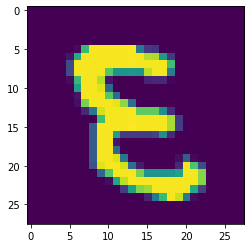

In [175]:
plt.imshow(np.fliplr(test_img))

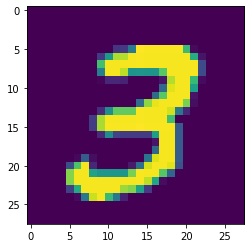

In [176]:
plt.imshow(test_img)

In [170]:
type(test_img)

numpy.ndarray

In [142]:
np.max(test_img)

1.0

In [115]:
t_ar = np.arange(16).reshape(4,4)

In [117]:
t_ar

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [116]:
np.fliplr(t_ar)

array([[ 3,  2,  1,  0],
       [ 7,  6,  5,  4],
       [11, 10,  9,  8],
       [15, 14, 13, 12]])

In [174]:
def symmetry(img, axis="vertical"):
    """Calculate a vertical symmetry score for normalized pictures.
    
    Parameters:
    img :: np.array
        Numpy array representing image. Pixel values in range [0,1]
    
    Returns:
    
    sym_score :: float 
        Value representing symmetrie score between 0 (not symmetric) and 1 (symmetric).
    """
    
    
    
    if axis == "vertical":
        flipped_img = np.fliplr(img)

    elif axis == "horizontal":
        flipped_img = np.flipud(img)
    
    else:
        # diagonal
        flipped_img = np.flipud(np.fliplr(img))
    

    sym_score = 1 - np.mean(np.abs(img - flipped_img))
    
    
    return sym_score
    
    
    

In [196]:
symmetry(test_img, "horizontal")

0.8168767392635345

In [240]:
eight_indices = np.where(y_train==8)
four_indices =  np.where(y_train==4)
six_indices =  np.where(y_train==4)
eight_training_samples = x_train[eight_indices]
four_training_samples = x_train[four_indices]
six_training_samples = x_train[six_indices]

In [105]:
def symmetry(imgs, axis="both"):
    """Calculate a symmetry score for normalized pictures.
    
    Parameters:
    img :: np.array
        Numpy array representing images. Pixel values in range [0,1]
    
    Returns:
    
    sym_score :: float 
        Value representing symmetrie score between 0 (not symmetric) and 1 (symmetric).
    """
    
    # crop image to area of non-zero pixels only
    
    # TODO
    
    if len(imgs.shape) < 3:
        # only single image passed -> expand dims
        imgs = np.expand_dims(imgs, axis=0)
    
    if len(imgs.shape) < 4:
        # no channel for images -> add channel dim
        imgs = np.expand_dims(imgs, axis=3)
    
    # print(imgs.shape)
    if axis == "vertical":
        # print("vertical")
        flipped_imgs = tf.image.flip_left_right(imgs)

    elif axis == "horizontal":
        # print("horizontal")
        flipped_imgs = tf.image.flip_up_down(imgs)
    
    else:
        # diagonal
        # print("both v. and h.")
        flipped_imgs = tf.image.flip_up_down(tf.image.flip_left_right(imgs))
    
    # print(tf.reduce_mean(tf.abs(flipped_imgs - imgs), axis=[1, 2, 3]).shape)
    sym_score = tf.reduce_mean(1 - tf.reduce_mean(tf.abs(flipped_imgs - imgs), axis=[1, 2, 3]))
    
    return sym_score
    
    
    

In [302]:
symmetry(six_training_samples)

(4859, 28, 28, 1)
vertical
(4859,)


<tf.Tensor: shape=(), dtype=float32, numpy=0.87357384>

In [303]:
symmetry(eight_training_samples)

(4842, 28, 28, 1)
vertical
(4842,)


<tf.Tensor: shape=(), dtype=float32, numpy=0.8471952>

### Intermediate Results 02.04.2022
- Symmetry is highly senesitive to small translations of images, thus not really reliable in the way it is implemented.
- the concept of symmetry is hard though, so not really a way to improve on above-mentioned issue though

## Session 14.04.2022

In [167]:
def determine_box(img):
    """Determine non-black area of image.
    
    Provide coordinates for cropping images to area which is filled.
    
    Parameters: 
    
    img :: np.ndarray
    """
    
    hc = np.where(img!=0)[0]
    wc = np.where(img!=0)[1]
    ul = (np.min(hc), np.min(wc))
    lr = (np.max(hc), np.max(wc))
    cropped_img = img[ul[0]:lr[0], ul[1]:lr[1]]
    
    return cropped_img

array([], dtype=float64)

In [19]:
def determine_box(imgs):
    """Determine non-black area of image.
    
    Provide coordinates for cropping images to area which is filled.
    
    Parameters: 
    
    img :: np.ndarray
    """
    
    if not len(imgs.shape) == 3:
        raise Exception("Check dimensions.")
    
    cropped_imgs = []
    for i in range(imgs.shape[0]):
        img = imgs[i, :, :]
        hc = np.where(img!=0)[0]
        wc = np.where(img!=0)[1]
        ul = (np.min(hc),np.min(wc))
        lr = (np.max(hc), np.max(wc))
        cropped_imgs.append(np.expand_dims(img[ul[0]:lr[0], ul[1]:lr[1]], axis=(0,3)))
    return cropped_imgs

In [20]:
temp = determine_box(x_train)

In [23]:
excerpt = temp[:2]

In [24]:
tf.image.flip_left_right(excerpt)

2022-04-15 19:08:18.809572: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [7]:
el = []
for i in range(10):
    el.append(np.ones(i))

In [13]:
np.asarray(el, dtype='object')

array([array([], dtype=float64), array([1.]), array([1., 1.]),
       array([1., 1., 1.]), array([1., 1., 1., 1.]),
       array([1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1.]),
       array([1., 1., 1., 1., 1., 1., 1.]),
       array([1., 1., 1., 1., 1., 1., 1., 1.]),
       array([1., 1., 1., 1., 1., 1., 1., 1., 1.])], dtype=object)

In [170]:
determine_box(x_train).shape

(59999, 27, 28)

In [172]:
tf.where(x_train != 0).shape

TensorShape([8994156, 3])

In [173]:
x_train.shape

(60000, 28, 28)

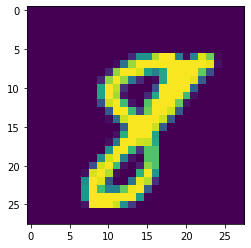

In [ ]:
plt.imshow(x_train[55])

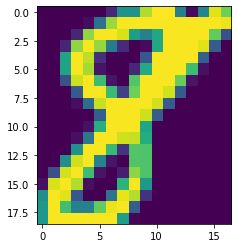

In [166]:
plt.imshow(determine_box(x_train[55]))

In [70]:
# tangent distance might be a solution to determine symmetry. Use it over the std. euclidean distance

In [116]:
print("Symmetry: ", symmetry(determine_box(x_train[55]/255).astype("float")))

(1, 19, 17, 1)
vertical
(1,)
Symmetry:  tf.Tensor(0.5933709706792933, shape=(), dtype=float64)


In [151]:
print("Symmetry: ", symmetry(determine_box(one/255).astype("float"), axis="vertical"))
print("Symmetry: ", symmetry(determine_box(one/255).astype("float"), axis="horizontal"))
print("Symmetry: ", symmetry(determine_box(one/255).astype("float")))

(1, 19, 4, 1)
vertical
(1,)
Symmetry:  tf.Tensor(0.1944272445820432, shape=(), dtype=float64)
(1, 19, 4, 1)
horizontal
(1,)
Symmetry:  tf.Tensor(0.8518059855521156, shape=(), dtype=float64)
(1, 19, 4, 1)
both v. and h.
(1,)
Symmetry:  tf.Tensor(0.18658410732714126, shape=(), dtype=float64)


In [152]:
print("Symmetry: ", symmetry(determine_box(x_train[55]/255).astype("float"), axis="vertical"))
print("Symmetry: ", symmetry(determine_box(x_train[55]/255).astype("float"), axis="horizontal"))
print("Symmetry: ", symmetry(determine_box(x_train[55]/255).astype("float")))

(1, 19, 17, 1)
vertical
(1,)
Symmetry:  tf.Tensor(0.5933709706792933, shape=(), dtype=float64)
(1, 19, 17, 1)
horizontal
(1,)
Symmetry:  tf.Tensor(0.5651065379712257, shape=(), dtype=float64)
(1, 19, 17, 1)
both v. and h.
(1,)
Symmetry:  tf.Tensor(0.6717537789109452, shape=(), dtype=float64)


In [164]:
print("Symmetry: ", symmetry(determine_box(x_train[11]/255).astype("float"), axis="vertical"))
print("Symmetry: ", symmetry(determine_box(x_train[11]/255).astype("float"), axis="horizontal"))
print("Symmetry: ", symmetry(determine_box(x_train[11]/255).astype("float")))

(1, 13, 19, 1)
vertical
(1,)
Symmetry:  tf.Tensor(0.6274668571882195, shape=(), dtype=float64)
(1, 13, 19, 1)
horizontal
(1,)
Symmetry:  tf.Tensor(0.6374057315233785, shape=(), dtype=float64)
(1, 13, 19, 1)
both v. and h.
(1,)
Symmetry:  tf.Tensor(0.7679765023418275, shape=(), dtype=float64)


### Status 15.04.2022:
- Die Box Methode scheint einen verlässlicheren Score zu geben, allerdings ist sie nicht einfach andwendbar auf batches, da jedes Bild individuell eine Größe hat. DAmit ist die Handhabung in Batches nicht möglich. 

In [26]:
tf.reduce_mean(x_train, axis=[1,2])

<tf.Tensor: shape=(60000,), dtype=uint8, numpy=array([35, 39, 24, ..., 28, 26, 26], dtype=uint8)>

In [40]:
def avg_pixel_intensity(img_tensor, batch_mean=False):
    """Calculate avg. pixel intensity.
    
    img_tensor :: array of 3 dim, pixel value between 0 and 1.
    """
    if batch_mean: 
        return tf.reduce_mean(tf.reduce_mean(img_tensor, axis=[1,2]), axis=0)
        
    
    return tf.reduce_mean(img_tensor, axis=[1,2])

    
    

In [33]:
avg_pixel_intensity(x_train/255)

<tf.Tensor: shape=(60000,), dtype=float64, numpy=
array([0.13768007, 0.15553721, 0.0972539 , ..., 0.11070428, 0.10218087,
       0.10464186])>

In [120]:
ones = x_train[y_train==1]
twos = x_train[y_train==2]
threes = x_train[y_train==3]
fours = x_train[y_train==4]
fives = x_train[y_train==5]
sixes = x_train[y_train==6]
sevens = x_train[y_train==7]
eights = x_train[y_train==8]
nines = x_train[y_train==9]
zeroes = x_train[y_train==0]

In [121]:
y_ones = y_train[y_train==1]
y_twos = y_train[y_train==2]
y_threes = y_train[y_train==3]
y_fours = y_train[y_train==4]
y_fives = y_train[y_train==5]
y_sixes = y_train[y_train==6]
y_sevens = y_train[y_train==7]
y_eights = y_train[y_train==8]
y_nines = y_train[y_train==9]
y_zeroes = y_train[y_train==0]

In [41]:
avg_pixel_intensity(x_train/255, batch_mean=True)

<tf.Tensor: shape=(), dtype=float64, numpy=0.1306604762738429>

In [48]:
print(avg_pixel_intensity(zeroes/255, batch_mean=True))
print(avg_pixel_intensity(ones/255, batch_mean=True))
print(avg_pixel_intensity(twos/255, batch_mean=True))
print(avg_pixel_intensity(threes/255, batch_mean=True))
print(avg_pixel_intensity(fours/255, batch_mean=True))
print(avg_pixel_intensity(fives/255, batch_mean=True))
print(avg_pixel_intensity(sixes/255, batch_mean=True))
print(avg_pixel_intensity(sevens/255, batch_mean=True))
print(avg_pixel_intensity(eights/255, batch_mean=True))
print(avg_pixel_intensity(nines/255, batch_mean=True))

tf.Tensor(0.17339932511920858, shape=(), dtype=float64)
tf.Tensor(0.07599864255996082, shape=(), dtype=float64)
tf.Tensor(0.14897512882292896, shape=(), dtype=float64)
tf.Tensor(0.14153014329202565, shape=(), dtype=float64)
tf.Tensor(0.12136559091284581, shape=(), dtype=float64)
tf.Tensor(0.1287493940575677, shape=(), dtype=float64)
tf.Tensor(0.13730177522174802, shape=(), dtype=float64)
tf.Tensor(0.11452769775108769, shape=(), dtype=float64)
tf.Tensor(0.15015598189369747, shape=(), dtype=float64)
tf.Tensor(0.12258994285224596, shape=(), dtype=float64)


Mögliche weitere Prädikate sind:
- 'lokale' Pixelintensität in einem Bereich


In [49]:
# - random functions
# - Erwartungswerte abh. von funktio f(x,u) übr Verteilung von u durch Monte Carlo approximieren als Auswertung

### 20.04.2022

In [114]:
def symmetry_boxed(imgs):
    # Asumme [0,1]-valued pixels
    cropped_imgs = determine_box(imgs)
    sym_scores = np.zeros(len(cropped_imgs))
    for j in range(len(imgs)):
        sym_scores[j] = symmetry(cropped_imgs[j])
    return sym_scores
    

In [131]:
sym_zeroes = symmetry_boxed(zeroes/255)
sym_ones = symmetry_boxed(ones/255)
sym_twos = symmetry_boxed(twos/255)
sym_threes = symmetry_boxed(threes/255)
sym_fours = symmetry_boxed(fours/255)
sym_fives = symmetry_boxed(fives/255)
sym_sixes = symmetry_boxed(sixes/255)
sym_sevens = symmetry_boxed(sevens/255)
sym_eights = symmetry_boxed(eights/255)
sym_nines = symmetry_boxed(nines/255)

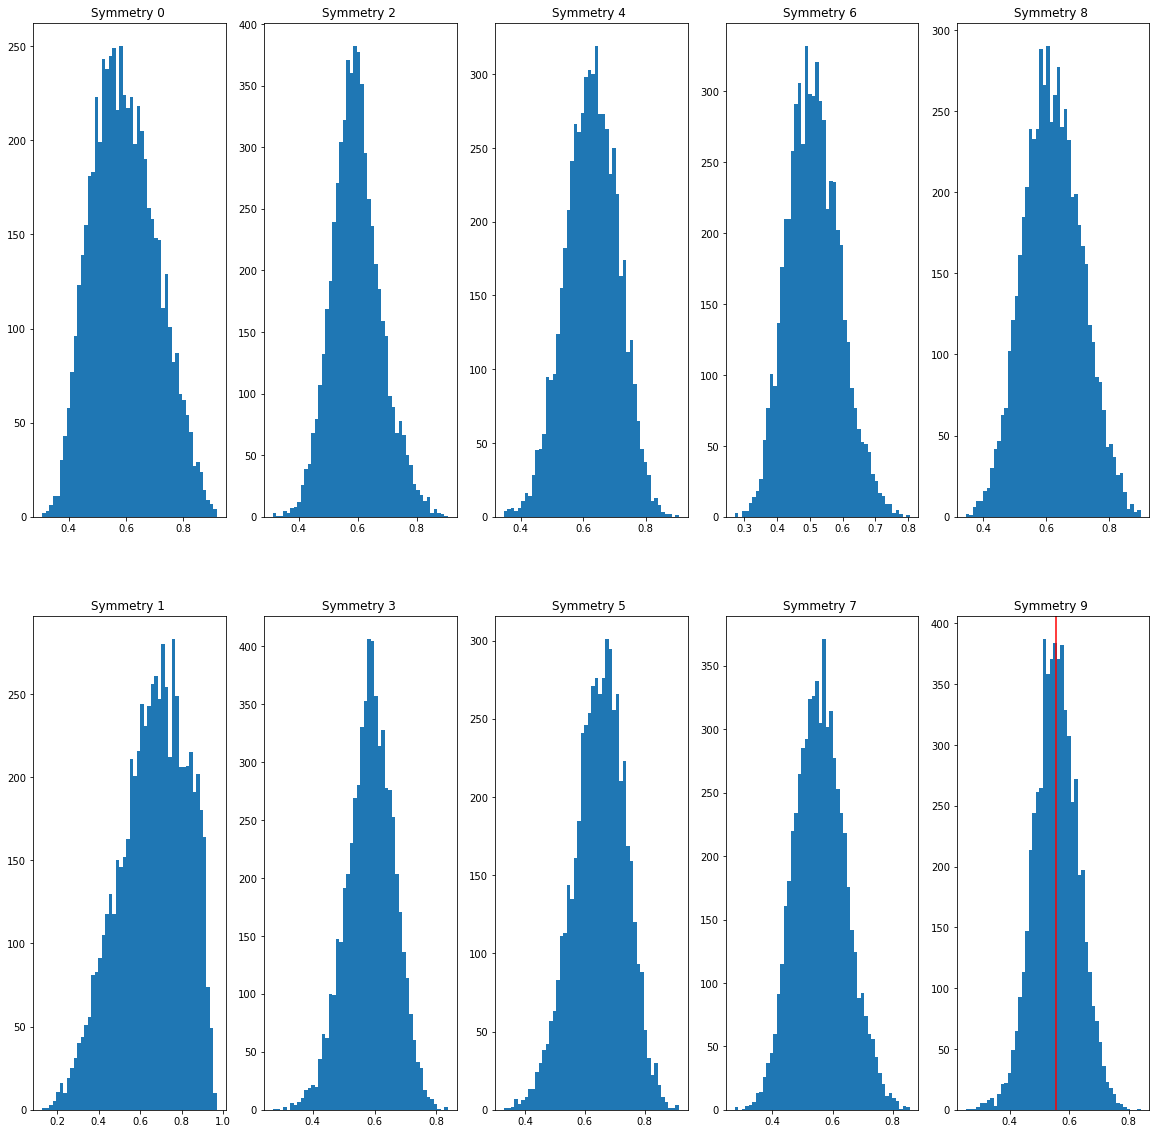

In [154]:
fig, axs = plt.subplots(2, 5, figsize=(20, 20))
axs[0, 0].hist(sym_zeroes, bins=50)
axs[0,0].title.set_text("Symmetry 0 ")
axs[1, 0].hist(sym_ones, bins=50)
axs[1, 0].title.set_text("Symmetry 1 ")
axs[0, 1].hist(sym_twos, bins=50)
axs[0, 1].title.set_text("Symmetry 2 ")
axs[1, 1].hist(sym_threes, bins=50)
axs[1, 1].title.set_text("Symmetry 3 ")
axs[0, 2].hist(sym_fours, bins=50)
axs[0, 2].title.set_text("Symmetry 4 ")
axs[1, 2].hist(sym_fives, bins=50)
axs[1, 2].title.set_text("Symmetry 5 ")
axs[0, 3].hist(sym_sixes, bins=50)
axs[0, 3].title.set_text("Symmetry 6 ")
axs[1, 3].hist(sym_sevens, bins=50)
axs[1, 3].title.set_text("Symmetry 7 ")
axs[0, 4].hist(sym_eights, bins=50)
axs[0, 4].title.set_text("Symmetry 8 ")
axs[1, 4].hist(sym_nines, bins=50)
axs[1, 4].axvline(np.mean(sym_nines), 0, 1.0, c='red')
axs[1, 4].title.set_text("Symmetry 9 ")

In [130]:
np.max(abs(b - sym_ones))sym_threes

0.006017600296697623

In [ ]:
twos_cropped = determine_box(twos/255)
sym_twos = np.zeros(len(twos_cropped))
for j in range(len(twos_cropped)):
    sym_twos[j] = symmetry(twos_cropped[j].astype('float16'))

(array([  3.,   1.,   1.,   6.,   3.,   7.,   8.,  17.,  29.,  35.,  51.,
         69.,  78., 112., 130., 179., 181., 249., 272., 324., 311., 372.,
        343., 403., 361., 343., 306., 256., 232., 196., 177., 162., 140.,
         99.,  89.,  73.,  72.,  64.,  53.,  40.,  27.,  22.,  19.,  13.,
         15.,   4.,   5.,   3.,   2.,   1.]),
 array([0.31298828, 0.32483398, 0.33667969, 0.34852539, 0.36037109,
        0.3722168 , 0.3840625 , 0.3959082 , 0.40775391, 0.41959961,
        0.43144531, 0.44329102, 0.45513672, 0.46698242, 0.47882813,
        0.49067383, 0.50251953, 0.51436523, 0.52621094, 0.53805664,
        0.54990234, 0.56174805, 0.57359375, 0.58543945, 0.59728516,
        0.60913086, 0.62097656, 0.63282227, 0.64466797, 0.65651367,
        0.66835938, 0.68020508, 0.69205078, 0.70389648, 0.71574219,
        0.72758789, 0.73943359, 0.7512793 , 0.763125  , 0.7749707 ,
        0.78681641, 0.79866211, 0.81050781, 0.82235352, 0.83419922,
        0.84604492, 0.85789063, 0.86973633, 0.

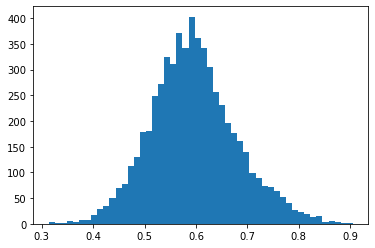

In [99]:
plt.hist(sym_twos, bins=50)

In [60]:
np.expand_dims(x_train[768]/255, axis=0).shape

(1, 28, 28)

In [92]:
ones_cropped = determine_box(ones/255)

In [93]:
ones_cropped[0].shape

(1, 19, 13, 1)

In [78]:
sym_ones = np.zeros(len(ones_cropped))

(array([  1.,   1.,   3.,   5.,  11.,  16.,  10.,  19.,  25.,  31.,  40.,
         44.,  51.,  56.,  81.,  83.,  91., 105., 118., 130., 118., 150.,
        146., 152., 163., 211., 201., 216., 244., 231., 243., 256., 261.,
        247., 280., 254., 212., 283., 249., 206., 206., 207., 215., 191.,
        202., 180., 164.,  74.,  49.,  10.]),
 array([0.12744141, 0.14430664, 0.16117187, 0.17803711, 0.19490234,
        0.21176758, 0.22863281, 0.24549805, 0.26236328, 0.27922852,
        0.29609375, 0.31295898, 0.32982422, 0.34668945, 0.36355469,
        0.38041992, 0.39728516, 0.41415039, 0.43101563, 0.44788086,
        0.46474609, 0.48161133, 0.49847656, 0.5153418 , 0.53220703,
        0.54907227, 0.5659375 , 0.58280273, 0.59966797, 0.6165332 ,
        0.63339844, 0.65026367, 0.66712891, 0.68399414, 0.70085937,
        0.71772461, 0.73458984, 0.75145508, 0.76832031, 0.78518555,
        0.80205078, 0.81891602, 0.83578125, 0.85264648, 0.86951172,
        0.88637695, 0.90324219, 0.92010742, 0.

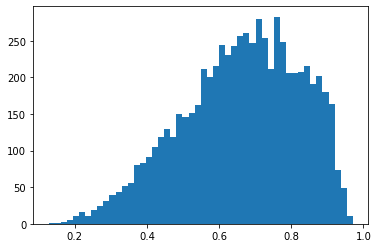

In [86]:
plt.hist(sym_ones, bins=50)

In [149]:
for j in range(len(ones_cropped)):
    sym_ones[j] = symmetry(ones_cropped[j].astype('float16'))

In [155]:
type(x_train)

numpy.ndarray

In [164]:
# for e in tf.data.Dataset.from_tensor_slices(x_train):
#     print(e)

## 22.04.2022

TF docu implementation

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)

    return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Der LUSI Loss $S(\theta, \mathcal{D}_n)$ ist wie folgt gegeben, falls nur faktorisierende Prädikate $\phi(x) \odot \tau(y)$ betrachtet werden:
$$ \begin{align*}
    S(\theta, \mathcal{D}_n) = \left \lVert\frac{1}{n}\sum_{j=1}^{n}\phi(x_j) \odot [\tau(y_j) - \tau(f_{\theta}(x_j)]\right \rVert_W^{2}.
    \end{align*}$$

Ein Schätzer von $\nabla_{\theta}S(\theta, \mathcal{D}_n)$ basierend auf Batches $J, J \prime$ der Größe $B, B\prime$ ist gegeben durch:
$$\begin{align*}
       \left [\frac{1}{B} \sum_{j \in J} \phi(x_j) \odot \frac{\partial \tau(f_{\theta}(x_j))}{\partial \theta}\right ]^T \cdot \left [W +            W^T \right ] \cdot \left [\frac{1}{B \prime} \sum_{j\prime \in J\prime}^n \phi(x_{j\prime})\odot[\tau(f_{\theta}(x_{j\prime})) -              \tau(y_{j\prime})]\right ] \text{.}
    \end{align*}$$

Insbesondere lassen sich die Werte $\phi(x_j)$ vorberechnen.

In [38]:
def dot(a,b,W):
    """Calculate a^T W b."""
    return np.dot(a, np.matmul(W, b))

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [241]:
v_1 = tf.constant([1,2,3], dtype=tf.float64, shape=[1,3])
v_2 = tf.constant([2,3,4], dtype=tf.float64, shape=[3,1])
# tf.tensordot(v_1, v_2, 1)
w_matrix = tf.constant(np.diag([1,1,1]), dtype=tf.float64)
tf.tensordot(v_1, tf.matmul(w_matrix, v_2), 1)

#tf.multiply(tf.convert_to_tensor(np.array([1,2,3])), tf.transpose(np.array([2,3,4])))

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[20.]])>

In [240]:
type(v_1)

tensorflow.python.framework.ops.EagerTensor

In [243]:
def dot(a, b, W):
    """Calculate dot product between a, b using W as weight matrix.
    
    
    a :: tensor of dtype tf.float64
    transposed vector
    b :: tensor of dtype tf.float64
    non-transposed vector
    W :: tensor of dtype tf.float64
    matrix.
    """
    
    return tf.tensordot(a, tf.matmul(W, b), 1)   


In [244]:
dot(v_1, v_2, w_matrix)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[20.]])>

In [260]:
class LusiLossBasic(tf.losses.Loss):
    # for now, let tau = id
    def __init__(self, phi, W):
        
        """Initialize Loss object given predicates and weight matrix.
        
        Parameters:
            phi :: array of dim batch_size x (no. of predicates each mapping to R)
            The part of the predicate acting on X, already evaluated
            
            tau :: array of dim batch_size x (no. of predicates each mapping to R)
            The part of the predicate acting on Y, as functions
            
            W :: weight matrix of adequate dimensions.
            
        """
        # Assume that predicates are factorizing, that is of form phi(x)tau(y)
        super.__init__()
        self.phi = phi
        self.W = W
        
    def call(self, y_pred, y_true):
        return dot(self.phi * (y - y_pred), self.W, self.phi * (y - y_pred))
        

In [7]:
# Define a simple neural network with one hidden layer and one output layer
nn_bin_class = keras.Sequential(
    [
        layers.Flatten(input_shape=(28,28), name="flatten_input"),  # declare shape of one input beforehand
        layers.Dense(500, activation="relu", name="hidden_layer_01"),
        layers.Dense(1, name="output_layer", activation="sigmoid"), # interpret output as prob. for class 1
    ]
)
# Call model on a test input
x = tf.ones((2,28,28))

y = nn_bin_class(x)




2022-05-02 16:20:11.908883: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
y

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.4028263],
       [0.4028263]], dtype=float32)>

In [9]:

nn_bin_class.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

### Learnings

Die Loss Funktion kann nicht von den Prädikaten abhängen in diesem einfachen Sinne, wie für LusiLossBasic definiert.
Wenn ich neue Daten habe, kann ich diese ja nicht nachträglich mit in den Loss schieben....

-> Ich muss also rein theoretisch die Prädikate mit in die Klasse aufnehmen als Funktionen.
Problem: Dann muss ich auch die zu den Labels gehörenden X-Daten mit aufnehmen. NIcht plausibel, siehe **LusiLossBasic2nd

-> From scratch Implementierung in tensorflow notwendig?

In [261]:
# Neuer Versuch
class LusiLossBasic2nd(tf.losses.Loss):
    # for now, let tau = id
    def __init__(self, phi, tau, W):
        
        """Initialize Loss object given predicates and weight matrix.
        
        Parameters:
            phi :: list
            array of predicates over X space.
            
            
            tau :: list
            array of predicates over Y space.
            
            W :: weight matrix of adequate dimensions.
            
        """
        # Assume that predicates are factorizing, that is of form phi(x)tau(y)
        
        # Check if dims are ok
        if not (len(phi) == W.shape[0] and len(tau) == w.shape[0] and W.shape[0] == W.shape[1]):
            raise Exception("Check dims.")

        # if dims are ok, continue
        super.__init__()
        self.phi = phi
        self.tau = tau
        self.W = W
    
    
    def call(self, y_pred, y_true):
        return dot(self.phi * (y - y_pred), self.W, self.phi * (y - y_pred))
        

### From Scratch Implementierung

see this <a href="https://medium.com/analytics-vidhya/how-to-write-a-neural-network-in-tensorflow-from-scratch-without-using-keras-e056bb143d78">link</a> for an implementation of a neural net in tensorflow without keras from scratch.

In [358]:
batch_size = 32
# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [272]:
for (i,j) in enumerate(train_dataset):
    if i < 10:
        print(i, j[0].shape,j[1].shape)

0 (32, 28, 28) (32,)
1 (32, 28, 28) (32,)
2 (32, 28, 28) (32,)
3 (32, 28, 28) (32,)
4 (32, 28, 28) (32,)
5 (32, 28, 28) (32,)
6 (32, 28, 28) (32,)
7 (32, 28, 28) (32,)
8 (32, 28, 28) (32,)
9 (32, 28, 28) (32,)


Eine Strategie könnte daraus bestehen, die tf Dataset Klasse zu überarbeiten und mehrere Batches auf einmal auszugeben -> neue Klasse

In [279]:
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_util

In [278]:
t_bool = ops.convert_to_tensor(True)

In [281]:
t_bool_const = tensor_util.constant_value(t_bool)

In [283]:

type(t_bool_const)

numpy.bool_

In [285]:
type(np.True_)

numpy.bool_

In [288]:
type(tensor_util.constant_value(ops.convert_to_tensor(64)))

numpy.int32

In [290]:
from tensorflow.python.util import _pywrap_utils

In [303]:
help(_pywrap_utils.FlattenForData)

Help on built-in function FlattenForData in module tensorflow.python.util._pywrap_utils:

FlattenForData(...) method of builtins.PyCapsule instance
    FlattenForData(arg0: handle) -> object
    
    
    Returns a flat sequence from a given nested structure.
    
    If `nest` is not a sequence, this returns a single-element list: `[nest]`.
    
    Args:
      nest: an arbitrarily nested structure or a scalar object.
        Note, numpy arrays are considered scalars.
    
    Returns:
      A Python list, the flattened version of the input.



In [301]:
_pywrap_utils.FlattenForData({1:[2,3,4], 2:[1,0,-1]})

[[2, 3, 4], [1, 0, -1]]

In [327]:
_pywrap_utils.FlattenForData(((((1,2),3),4),(5,6), 7))

[1, 2, 3, 4, 5, 6, 7]

In [305]:
zip(*_pywrap_utils.FlattenForData(((1,2),3)))

TypeError: 'int' object is not iterable

In [306]:
help(*)

SyntaxError: invalid syntax (2697577169.py, line 1)

In [311]:
print(zip(*['A', 'n', 'd', 'y']))

In [315]:
help(zip(*['A', 'n', 'd', 'y']))

Help on zip object:

class zip(object)
 |  zip(*iterables, strict=False) --> Yield tuples until an input is exhausted.
 |  
 |     >>> list(zip('abcdefg', range(3), range(4)))
 |     [('a', 0, 0), ('b', 1, 1), ('c', 2, 2)]
 |  
 |  The zip object yields n-length tuples, where n is the number of iterables
 |  passed as positional arguments to zip().  The i-th element in every tuple
 |  comes from the i-th iterable argument to zip().  This continues until the
 |  shortest argument is exhausted.
 |  
 |  If strict is true and one of the arguments is exhausted before the others,
 |  raise a ValueError.
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.
 |  
 |  __setstate__(...)
 |      Set state information for unpickling.
 |  
 |  ------------------

In [320]:
print(*[[0,1],[2,3],[4,5]])

[0, 1] [2, 3] [4, 5]


In [321]:
a = [[0,1],[2,3],[4,5]]
print(a)

[[0, 1], [2, 3], [4, 5]]


In [322]:
b = zip(*a)

In [324]:
print(list(b))

[(0, 2, 4), (1, 3, 5)]


In [334]:
type(train_dataset.element_spec[1])

tensorflow.python.framework.tensor_spec.TensorSpec

In [338]:
train_dataset.element_spec

(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.float32, name=None))

In [335]:
help(tensorflow.python.framework.tensor_spec.TensorSpec)

NameError: name 'tensorflow' is not defined

In [336]:
from tensorflow.python.framework.tensor_spec import TensorSpec

In [337]:
help(TensorSpec)

Help on class TensorSpec in module tensorflow.python.framework.tensor_spec:

class TensorSpec(DenseSpec, tensorflow.python.framework.type_spec.BatchableTypeSpec)
 |  TensorSpec(shape, dtype=tf.float32, name=None)
 |  
 |  Describes a tf.Tensor.
 |  
 |  Metadata for describing the `tf.Tensor` objects accepted or returned
 |  by some TensorFlow APIs.
 |  
 |  Method resolution order:
 |      TensorSpec
 |      DenseSpec
 |      tensorflow.python.framework.type_spec.BatchableTypeSpec
 |      tensorflow.python.framework.type_spec.TypeSpec
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  is_compatible_with(self, spec_or_tensor)
 |      Returns True if spec_or_tensor is compatible with this TensorSpec.
 |      
 |      Two tensors are considered compatible if they have the same dtype
 |      and their shapes are compatible (see `tf.TensorShape.is_compatible_with`).
 |      
 |      Args:
 |        spec_or_tensor: A tf.TensorSpec or a tf.Tensor
 |      
 |      Returns:
 |    

In [363]:

#help(train_dataset.batch(32))
train_dataset.batch(32).element_spec
list(train_dataset.batch(32, drop_remainder=True).as_numpy_iterator())[0][1]

array([5., 0., 4., 1., 9., 2., 1., 3., 1., 4., 3., 5., 3., 6., 1., 7., 2.,
       8., 6., 9., 4., 0., 9., 1., 1., 2., 4., 3., 2., 7., 3., 8.],
      dtype=float32)

### 02.05.2022

#### I. LUSI for gradient descent on entire training data

In [31]:
f_1 = lambda x: x
f_2 = lambda x: x**2
f_3 = lambda x: x**3
f_4 = lambda x: x**4

f = np.array([f_1, f_2, f_3, f_4])
y = np.arange(10)

In [32]:
y_f = [f[i](y[j]) for j in range(y.shape[0])  for i in range(f.shape[0])]

In [33]:
y_f = np.asarray(y_f).reshape(y.shape[0], f.shape[0])

In [34]:
print(y_f)

[[   0    0    0    0]
 [   1    1    1    1]
 [   2    4    8   16]
 [   3    9   27   81]
 [   4   16   64  256]
 [   5   25  125  625]
 [   6   36  216 1296]
 [   7   49  343 2401]
 [   8   64  512 4096]
 [   9   81  729 6561]]


In [35]:
phi_x = np.random.randint(0, 10, size=(y.shape[0], f.shape[0]))
phi_x

array([[6, 7, 1, 7],
       [9, 1, 0, 1],
       [6, 7, 0, 1],
       [7, 4, 8, 8],
       [0, 0, 5, 5],
       [1, 6, 5, 4],
       [1, 0, 9, 0],
       [0, 0, 4, 6],
       [5, 5, 2, 4],
       [6, 8, 7, 7]])

In [36]:
phi_x * y_f

array([[    0,     0,     0,     0],
       [    9,     1,     0,     1],
       [   12,    28,     0,    16],
       [   21,    36,   216,   648],
       [    0,     0,   320,  1280],
       [    5,   150,   625,  2500],
       [    6,     0,  1944,     0],
       [    0,     0,  1372, 14406],
       [   40,   320,  1024, 16384],
       [   54,   648,  5103, 45927]])

In [263]:
# Neuer Versuch
class LusiLossNoBatch(tf.losses.Loss):
    # for now, let tau = id
    def __init__(self, phi_x, tau, W):
    
        
        """Initialize Loss object given predicates and weight matrix.
        
        Parameters:
            phi :: list
            array of evaluations of predicates over space X
            dims: (batch_size, no_of_predicates)
            
            tau :: list
            array of predicates over Y space.
            
            W :: symmetric, positive definite weight matrix
                 of adequate dimensions.
        """
        
        # Assume that predicates are factorizing, that is of form phi(x)tau(y)
        
        # Check if dims are ok
        if not (tau.shape[0] == W.shape[0] and W.shape[0] == W.shape[1]):
            raise Exception("Check dims tau and W.")

        # if dims are ok, continue
        super().__init__()
        self.phi_x = phi_x
        self.tau = tau
        self.W = W
    
    
    def call(self, y_pred, y_true):
        # y_pred and y_true expected to have dims (batch_size, d0, ..., dN) where di means dimension i.
        # Explicitly for bin. class: dims are given by (batch_size, d0)
        
        if not y_true.shape[0] == y_pred.shape[0]:
            raise Exception("Check dims y-values.")
        
        if not self.phi_x.shape[1] == self.tau.shape[0]:
            raise Exception("Check dims tau and phi_x")
        
        if not self.phi_x.shape[0] == y_pred.shape[0]:
            print(self.phi_x.shape[0], y_pred.shape[0])
            raise Exception("Check dims y and phi_x")
        
        # for each y, we get vector [tau_1(y), ..., tau_d(y)], same for y_pred
        y_dim = y_true.shape[0]
        
        y_tau = [self.tau[i](y_true[j]) for j in range(y_true.shape[0])  for i in range(self.tau.shape[0])]
        # y_true = np.asarray(y_tau)
        # y_true = y_true.reshape(y_dim, self.tau.shape[0])
        
        
        y_true = tf.convert_to_tensor(y_tau, dtype=tf.float64)
        y_true = tf.reshape(y_true, [y_dim, self.tau.shape[0]])

        
        y_pred_tau = [self.tau[i](y_pred[j]) for j in range(y_pred.shape[0])  for i in range(self.tau.shape[0])]
#         y_pred = np.asarray(y_pred_tau)
#         y_pred.reshape(y_dim, self.tau.shape[0])
        y_pred = tf.convert_to_tensor(y_pred_tau, dtype=tf.float64)
        y_pred = tf.reshape(y_pred,[y_dim, self.tau.shape[0]])
        

        
        no_weight_loss = tf.reduce_mean(self.phi_x * (y_true - y_pred), axis=0)
        # no_weight_loss should be tensor of dims (1, no_of_predicates)
        no_weight_loss = tf.reshape(no_weight_loss, [self.tau.shape[0],1])
        # no_weight_loss = tf.reduce_mean(self.phi_x * (y - y_), axis=0)

        return dot(tf.transpose(no_weight_loss), no_weight_loss, self.W)
        #return tf.square(y_true-y_pred)   
        

##### Try to fit model using this loss function

In [255]:
v_1.shape

TensorShape([1, 3])

In [45]:
x_train[1].shape
tf.reduce_mean(x_train[1], axis=0)

<tf.Tensor: shape=(28,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08613446, 0.3144258 , 0.37492996, 0.27254903,
       0.22801122, 0.2401961 , 0.24845941, 0.24845938, 0.2245098 ,
       0.25210086, 0.3053221 , 0.28557426, 0.20714286, 0.22675072,
       0.3943978 , 0.3114846 , 0.13459383, 0.        , 0.        ,
       0.        , 0.        , 0.        ], dtype=float32)>

In [49]:
np.ones(10).reshape(5,2)

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [50]:
np.arange(10).reshape(5,2)

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [51]:
np.ones(10).reshape(5,2)*np.arange(10).reshape(5,2)

array([[0., 1.],
       [2., 3.],
       [4., 5.],
       [6., 7.],
       [8., 9.]])

In [53]:
tf.reduce_mean(np.ones(10).reshape(5,2)*np.arange(10).reshape(5,2), axis=1)

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.5, 2.5, 4.5, 6.5, 8.5])>

-> reduce along axis 0 means reducing along rows, that is keeping columns

In [54]:
# I. Define predicates on image data
avg_pixel_intensity = lambda x: tf.reduce_mean(x)

In [66]:
# np.arange(1,15)
np.arange(14, 0, -1)

array([14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [69]:
np.concatenate([np.arange(1,15), np.arange(14, 0, -1)]).shape

(28,)

In [70]:
def weighted_pixel_intesity(x):
    row_mean = tf.reduce_mean(x, axis=1)
    weights = np.concatenate([np.arange(1,15), np.arange(14, 0, -1)])
    weighted_intesity = row_mean * weights
    return np.mean(weighted_intesity)

Setting is supervised learning setting, i.e. the problem is to find prob. measure on $\mathcal{X \times Y}$

Predicates are of the form $\phi(x)\tau(y)$

In [78]:
def local_pixel_intensity(x, patch):
    """Calc. avg. pixel intensity on local patch of image.
    
    x :: np.array
    dims = (batch, 28, 28).
    
    patch :: tuple[tuple]
    coordinates for patch. Tuple structure as follows: ((x_dim_0, x_dim_1), (y_dim_0, y_dim_1)).

    """
    
    extracted_patch = x[:, patch[0][0]:patch[0][1], patch[1][0]: patch[1][1]]
    return tf.reduce_mean(extracted_patch)

In [108]:
def local_pixel_intensity_single(x, patch):
    # TODO: Find a way to accomodate single sample eval in the original function
    
    """Calc. avg. pixel intensity on local patch of image.
    
    x :: np.array
    dims = (28, 28).
    
    patch :: tuple[tuple]
    coordinates for patch. Tuple structure as follows: ((x_dim_0, x_dim_1), (y_dim_0, y_dim_1)).

    """
    
    extracted_patch = x[patch[0][0]:patch[0][1], patch[1][0]: patch[1][1]]
    return tf.reduce_mean(extracted_patch)

In [71]:
def phi_x(predicates, x):
    """ Evaluate predicates on data and store values.
    
    predicates :: np.array
    List of \R valued predicates working on x of dimension d.
    
    x :: np.array
    data to apply predicates to of dimensinos (n, d0, ..., dN).
    I.e. for MNIST, dims = (n, 28, 28)
    
    returns:
    array of dimensions (n, d).
    """
    
    pred_evals = np.asarray([predicates[i](x[j]) for j in range(x.shape[0]) for i in range(predicates.shape[0])])
    pred_evals = pred_evals.reshape(x.shape[0], predicates.shape[0])
    
    
    return pred_evals

In [92]:
import functools

In [104]:
local_pixel_intensity_center = functools.partial(local_pixel_intensity_single, patch=((10,20), (10,20)))

In [112]:
phi = np.asarray([avg_pixel_intensity, weighted_pixel_intesity, local_pixel_intensity_center])


In [113]:
phi_x(phi, x_train[:1000, :, :]/255).shape

(1000, 3)

In [272]:
identity = lambda x: x
tau = np.asarray([identity, identity, identity])
# tau = tf.convert_to_tensor([identity, identity, identity])
# Cannot convert a list of functions to a tensor

In [117]:
phi

array([<function <lambda> at 0x19e43c820>,
       <function weighted_pixel_intesity at 0x19e276950>,
       functools.partial(<function local_pixel_intensity_single at 0x19ef644c0>, patch=((10, 20), (10, 20)))],
      dtype=object)

In [252]:
w_matrix = tf.convert_to_tensor(np.diag(np.ones(3)), dtype=tf.float64)

In [ ]:
# Data: sevens, eights
# sevens, eights
# y_sevens, y_eights

In [122]:
# Define a simple neural network with one hidden layer and one output layer
nn_bin_class = keras.Sequential(
    [
        layers.Flatten(input_shape=(28,28), name="flatten_input"),  # declare shape of one input beforehand
        layers.Dense(500, activation="relu", name="hidden_layer_01"),
        layers.Dense(1, name="output_layer", activation="sigmoid"), # interpret output as prob. for class 1
    ]
)

In [296]:
nn_bin_class(x_train).shape

TensorShape([400, 1])

In [130]:
eights.shape

(4842, 28, 28)

In [202]:
sevens_lusi = sevens[:200]
eights_lusi = eights[:200]
y_sevens_lusi = np.zeros(200)
y_eights_lusi = np.ones(200)

In [203]:
x_train = np.concatenate([sevens_lusi, eights_lusi])
y_train = np.concatenate([y_sevens_lusi, y_eights_lusi])

In [204]:
x_train.shape

(400, 28, 28)

In [205]:
y_train.shape

(400,)

In [206]:
type(x_train)

numpy.ndarray

In [207]:
phi_eval = phi_x(phi, x_train/255)

In [208]:
phi_eval.shape

(400, 3)

In [246]:
type(tf.convert_to_tensor(phi_eval))

tensorflow.python.framework.ops.EagerTensor

In [194]:
type(y_train)

numpy.ndarray

In [264]:
nn_bin_class.compile(
    optimizer=keras.optimizers.RMSprop(),
    # loss=keras.losses.SparseCategoricalCrossentropy(),
    loss=LusiLossNoBatch(phi_eval, tau, w_matrix),
    metrics=[keras.metrics.Accuracy()],
)

In [265]:
hist_nn_bin_class = nn_bin_class.fit(
    x_train,
    y_train,
    batch_size=x_train.shape[0],
    epochs=100
    #validation_data=(x_val, y_val)  add argument
)

Epoch 1/100
1/1 [==============================] - 20s 20s/step - loss: 9.0503e-11 - accuracy: 0.0175
Epoch 2/100
1/1 [==============================] - 0s 12ms/step - loss: 1.2874e-10 - accuracy: 0.0175
Epoch 3/100
1/1 [==============================] - 0s 19ms/step - loss: 1.1891e-10 - accuracy: 0.0175
Epoch 4/100
1/1 [==============================] - 0s 10ms/step - loss: 5.9916e-11 - accuracy: 0.0175
Epoch 5/100
1/1 [==============================] - 0s 13ms/step - loss: 1.1563e-10 - accuracy: 0.0175
Epoch 6/100
1/1 [==============================] - 0s 17ms/step - loss: 1.2076e-10 - accuracy: 0.0175
Epoch 7/100
1/1 [==============================] - 0s 13ms/step - loss: 1.0294e-10 - accuracy: 0.0175
Epoch 8/100
1/1 [==============================] - 0s 16ms/step - loss: 1.3313e-10 - accuracy: 0.0175
Epoch 9/100
1/1 [==============================] - 0s 16ms/step - loss: 1.2168e-10 - accuracy: 0.0175
Epoch 10/100
1/1 [==============================] - 0s 15ms/step - loss: 1.7659e-1

In [269]:
nn_bin_class.predict(sevens)

array([[0.00029203],
       [0.06547606],
       [0.00106779],
       ...,
       [0.00028142],
       [0.00041658],
       [0.00016576]], dtype=float32)

In [165]:
tf.convert_to_tensor([1,2,3,4])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

In [166]:
tf.reshape(tf.convert_to_tensor([1,2,3,4]), [2,2])

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 2],
       [3, 4]], dtype=int32)>

In [ ]:
        # Explicitly for bin. class - dims are given by (batch_size, d0)
        
        if not y_true.shape[0] == y_pred.shape[0]:
            raise Exception("Check dims y-values.")
        
        if not self.phi_x.shape[1] == self.tau.shape[0]:
            raise Exception("Check dims tau and phi_x")
        
        if not self.phi_x.shape[0] == y_pred.shape[0]:
            raise Exception("Check dims y and phi_x")
        
        y_dim = y_true.shape[0]

        # for each y_true, calc vector [tau_1(y_true), ..., tau_d(y_true)], same for y_pred
        y_tau = [self.tau[i](y_true[j]) for j in range(y_true.shape[0])  for i in range(self.tau.shape[0])]        
        y_true = tf.convert_to_tensor(y_tau, dtype=tf.float64)
        y_true = tf.reshape(y_true, [y_dim, self.tau.shape[0]])

        y_pred_tau = [self.tau[i](y_pred[j]) for j in range(y_pred.shape[0])  for i in range(self.tau.shape[0])]
        y_pred = tf.convert_to_tensor(y_pred_tau, dtype=tf.float64)
        y_pred = tf.reshape(y_pred,[y_dim, self.tau.shape[0]])
        

        
        no_weight_loss = tf.reduce_mean(self.phi_x * (y_true - y_pred), axis=0)
        # no_weight_loss should be tensor of dims (1, no_of_predicates)
        no_weight_loss = tf.reshape(no_weight_loss, [self.tau.shape[0],1])

        return dot(tf.transpose(no_weight_loss), no_weight_loss, self.W)

In [275]:
tf.linalg.diag([1,3,2])

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [0, 3, 0],
       [0, 0, 2]], dtype=int32)>

In [289]:
diags = tf.linalg.diag(np.array([[1,2,3],[4,5,6],[7,8,9]]))
vecs = tf.constant([[[1,1,1]],[[2,2,2]],[[3,3,3]]], dtype=tf.int64)
diags * vecs

<tf.Tensor: shape=(3, 3, 3), dtype=int64, numpy=
array([[[ 1,  0,  0],
        [ 0,  2,  0],
        [ 0,  0,  3]],

       [[ 8,  0,  0],
        [ 0, 10,  0],
        [ 0,  0, 12]],

       [[21,  0,  0],
        [ 0, 24,  0],
        [ 0,  0, 27]]])>

In [290]:
vecs

<tf.Tensor: shape=(3, 1, 3), dtype=int64, numpy=
array([[[1, 1, 1]],

       [[2, 2, 2]],

       [[3, 3, 3]]])>

In [294]:
tf.linalg.diag(phi_eval)[0, :, :]


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.0004962 , 0.        , 0.        ],
       [0.        , 0.00503395, 0.        ],
       [0.        , 0.        , 0.00153187]], dtype=float32)>

In [ ]:
def lusi_loss_batch(model, inputs, y_true, phi_x, tau, W):
    """Given batch, calculate loss and gradient of loss.
    
    Special gradient defined to get unbiased estimate of gradient.
    """
    
    
    if not y_true.shape[0] == y_pred.shape[0]:
        raise Exception("Check dims y-values.")

    if not self.phi_x.shape[1] == self.tau.shape[0]:
        raise Exception("Check dims tau and phi_x")

    if not self.phi_x.shape[0] == y_pred.shape[0]:
        raise Exception("Check dims y and phi_x")
    
    y_dim = y_true.shape[0]

    # for each y_true, calc vector [tau_1(y_true), ..., tau_d(y_true)], same for y_pred
    y_tau = [self.tau[i](y_true[j]) for j in range(y_true.shape[0])  for i in range(self.tau.shape[0])]        
    y_true = tf.convert_to_tensor(y_tau, dtype=tf.float64)
    y_true = tf.reshape(y_true, [y_dim, self.tau.shape[0]])
    
    y_pred = model(inputs)
    y_pred_tau = [self.tau[i](y_pred[j]) for j in range(y_pred.shape[0])  for i in range(self.tau.shape[0])]
    y_pred = tf.convert_to_tensor(y_pred_tau, dtype=tf.float64)
    y_pred = tf.reshape(y_pred,[y_dim, self.tau.shape[0]])

    no_weight_loss = tf.reduce_mean(self.phi_x * (y_true - y_pred), axis=0)
    # no_weight_loss should be tensor of dims (1, no_of_predicates)
    no_weight_loss = tf.reshape(no_weight_loss, [self.tau.shape[0],1])
    
    def grad(upstream):
        # unbiased estimate of gradient based on batches
        B = y_dim // 2
        B_prime = y_dim - B
            
        
        first_sum = 1/B * tf.linalg.diag(phi_x[:B])
        
        return None

    
    return dot(tf.transpose(no_weight_loss), no_weight_loss, self.W)
    